# Preliminary preparations

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr

import pytz

import requests
import re
import json
import os

Define necessary links and paths:<br>
1. [Alberta townships geospatial layer](https://geospatial-sit.alberta.ca/titan/rest/services/base/alberta_township_system/MapServer/7/query),
2. Anil Gupta's `.csv` data style (located in the `./assets` directory), and
3. Anil Gupta's list of Townships (located in the `./assets` directory).

In [2]:
# ArcGIS REST API endpoint for the specific ATS layer
alta_ats = "https://geospatial-sit.alberta.ca/titan/rest/services/base/alberta_township_system/MapServer/7/query"

# .csv data style
data_style = './assets/T001R19W4.csv'

# list of townships needed
township_list = [
    'T001R08W4',
    'T001R12W4',
    'T001R13W4',
    'T001R18W4',
    'T001R19W4',
    'T001R20W4',
    'T001R22W4',
    'T001R23W4',
    'T002R11W4',
    'T002R12W4',
    'T002R13W4',
    'T002R14W4',
    'T002R15W4',
    'T002R16W4',
    'T002R17W4',
    'T002R18W4',
    'T002R21W4',
    'T002R23W4'
]

# Extracting needed layers

In [3]:
# list of township IDs based on the `PID` column of the source ATS data
ids_list = [''.join(re.split("[TRW]", ats)[::-1]) for ats in township_list]

# string of list items
list_str = ', '.join([f"'{item}'" for item in ids_list])

# creating a custrom SQL query statement to find `ids_list` values in the `PID` column
sql_query = f"FILE_NAME IN ({list_str})"

In [4]:
# Specifying query parameters
params_ag = {
    'where': sql_query,
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'geojson',  # Output format as GeoJSON
}

# Make the request to the ArcGIS REST API
response_ag = requests.get(alta_ats, params=params_ag)

# Check if the request was successful
if response_ag.status_code == 200:
    # Load GeoJSON data into a GeoDataFrame
    gdf_ag = gpd.read_file(response_ag.text)
else:
    print(f"Error: {response_ag.status_code} - {response_ag.text}")

# Plotting the GIS layer (just for reassurance)

Since the data is accessed through the ESRI's REST API, and just out of abundance of caution, the results are analyzed just to make sure it all makes sense.

408001: present
412001: present
413001: present
418001: present
419001: present
420001: present
422001: present
423001: present
411002: present
412002: present
413002: present
414002: present
415002: present
416002: present
417002: present
418002: present
421002: present
423002: present


/tmp/ipykernel_18674/721271227.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_ag.centroid.plot(ax=ax, zorder=2, c='black')


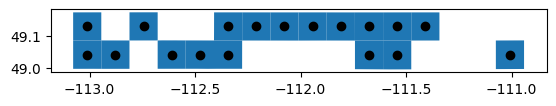

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

gdf_ag.plot(ax=ax, zorder=1)
gdf_ag.centroid.plot(ax=ax, zorder=2, c='black')

# Check if everything requested in the `township_list` is available in `gdf_ag`
for record in ids_list:
    if record in gdf_ag.FILE_NAME.to_list():
        print(f"{record}: present")

Here, it has been assumed that the township list names map to the `DESCRIPTOR` column of data. As an example:

* Township name of `T001R08W4` maps to `DESCRIPTOR` value of  `TWP-001 RGE-08 MER-4` and so on.

In [6]:
# printing the GeoDataFrame
gdf_ag

,PID,FILE_NAME,TRM,M,RGE,TWP,DESCRIPTOR,OBJECTID,SHAPE.STArea(),SHAPE.STLength(),geometry
0,419001,419001,001194,4,19,1,TWP-001 RGE-19 MER-4,158,0.011785,0.443881,"POLYGON ((-112.41021 48.99883, -112.41021 49.0..."
1,413002,413002,002134,4,13,2,TWP-002 RGE-13 MER-4,370,0.011649,0.441466,"POLYGON ((-111.62536 49.17359, -111.62572 49.1..."
2,411002,411002,002114,4,11,2,TWP-002 RGE-11 MER-4,1634,0.011654,0.441594,"POLYGON ((-111.37926 49.17368, -111.38062 49.1..."
3,416002,416002,002164,4,16,2,TWP-002 RGE-16 MER-4,1959,0.011660,0.441703,"POLYGON ((-112.00954 49.17366, -112.01234 49.1..."
4,418002,418002,002184,4,18,2,TWP-002 RGE-18 MER-4,2002,0.011630,0.441222,"POLYGON ((-112.33750 49.17373, -112.34289 49.1..."
5,418001,418001,001184,4,18,1,TWP-001 RGE-18 MER-4,2752,0.011703,0.442220,"POLYGON ((-112.31545 49.08647, -112.32094 49.0..."
6,415002,415002,002154,4,15,2,TWP-002 RGE-15 MER-4,2808,0.011661,0.441647,"POLYGON ((-112.00954 49.08620, -112.00926 49.0..."
7,414002,414002,002144,4,14,2,TWP-002 RGE-14 MER-4,3741,0.011678,0.442181,"POLYGON ((-111.82152 49.17359, -111.82180 49.1..."
8,412001,412001,001124,4,12,1,TWP-001 RGE-12 MER-4,3757,0.011959,0.445959,"POLYGON ((-111.48086 49.08632, -111.48635 49.0..."
9,420001,420001,001204,4,20,1,TWP-001 RGE-20 MER-4,3947,0.011701,0.441603,"POLYGON ((-112.62693 49.08680, -112.63238 49.0..."


In [7]:
# saving the results to an ESRI Shapefile in the `./results` directory
gdf_ag.to_file('./results/township_Shapefiles/townships.shp')

/tmp/ipykernel_18674/1237013570.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_ag.to_file('./results/township_Shapefiles/townships.shp')


# Processing `RDRSv2.1` for each township area

Using [`easymore v2.0.0`](https://github.com/ShervanGharari/EASYMORE.git)'s capability, we can extract the aerial average of precipitation (surface level) and air temperature (at 1.5 meters above surface level) for the list of townships extracted.

More specifically, the following variables are extracted using [`datatool 0.4.2-dev`](https://github.com/kasra-keshavarz/datatool) to be further processed:
* `RDRS_v2.1_P_PR0_SFC` [m]
* `RDRS_v2.1_P_TT_1.5m` [degrees Celcius]

The workflow to use `datatool` is as follows:

```console
foo@bar:~$ ./extract-dataset.sh 
    --dataset=RDRS \
    --dataset-dir=/project/rpp-kshook/Model_Output/RDRSv2.1 \
    --variable=RDRS_v2.1_P_PR0_SFC,RDRS_v2.1_P_TT_1.5m \
    --output-dir=/home/kasra545/scratch/township-ag/ \
    --start-date=1980-01-01 \
    --end-date=2018-12-31 \
    --lat-lims=48.8,49.5 \
    --lon-lims=-113.5,-110.5 \
    --prefix=smm_ \
    --email=kasra.keshavarz1@ucalgary.ca \
    -j;
```

## Merge `datatool` outputs
First, we set up a `Dask` distributed cluster:

In [ ]:
from dask.distributed import Client

scheduler_file = '/home/kasra545/dask/scheduler_466387918/scheduler.json' # local only, have your Dask cluster setup
client = Client(scheduler_file=scheduler_file)

In [ ]:
client.dashboard_link

Get a list of files:

In [ ]:
import glob

nc_files = glob.glob('/home/kasra545/scratch/township-ag/**/*.nc')

In [ ]:
# let's create only 1 netCDF file after merging everything
ds = xr.open_mfdataset(nc_files,
                       concat_dim="time",
                       combine="nested",
                       data_vars='minimal',
                       coords='minimal',
                       compat='override',
                       parallel=True,
                       engine='h5netcdf',
                      )

In [ ]:
ds

Saving merged dataset to a single netCDF file:

In [ ]:
ds.to_netcdf(path='/home/kasra545/scratch/township-ag/rdrs_abtownships2.nc',
             engine='netcdf4',
            )

Now, using easymore for remapping:

In [ ]:
# using easymore to create aerial average values
from easymore import Easymore

easymore_conf = {
    'case_name': 'SMM-AB Townships data',
    'target_shp': './results/townships.shp', 
    'target_shp_ID': 'PID',
    'temp_dir': '/home/kasra545/scratch/township-ag/temp_dir/', # only available locally
    'source_nc': '/home/kasra545/scratch/township-ag/rdrs_townships.nc', # only available locally as it is the `datatool`'s output
    'var_names': ['RDRS_v2.1_P_PR0_SFC', 'RDRS_v2.1_P_TT_1.5m'],
    'var_lon': 'lon',
    'var_lat': 'lat',
    'var_time': 'time',
    'remapped_var_id': 'PID',
    'remapped_dim_id': 'PID',
    'output_dir': '/home/kasra545/scratch/township-ag/', # only available locally
}

remap_exp = Easymore.from_dict(easymore_conf)

Run `easymore`:

In [ ]:
remap_exp.nc_remapper()

# Creating AG's style files

In [10]:
# lambda function for name extractions
convert = lambda x: 'T'+str(x[-3:])+'R'+str(x[1:3])+'W'+str(x[0])

# function to create custom .csv files
def create_csv_ag(
    da: xr.DataArray,
    df_ref: pd.DataFrame,
    tz_str: str = 'America/Edmonton'
) -> None:
    '''
    Create .csv file for AB AEP
    '''

    # time zone manipulations
    local_tz = pytz.timezone(tz_str)
    time_index = da['time'].to_index().tz_localize(pytz.UTC) # original time-zone
    time_index_local = time_index.tz_convert(local_tz) # local timezone-aware data
    dt_index = time_index_local.tz_localize(None) # naive-timezone MST data
    da = da.assign_coords({'time': dt_index})

    # daily accumulated precipitation in mm - hardcoded
    daily_prec = da['RDRS_v2.1_P_PR0_SFC'].resample({'time': 'D'}).sum(dim='time').to_pandas() * 1000 # in mm
    # daily maximum/minimum temperature values in degrees Celcius - hardcoded
    daily_tmax = da['RDRS_v2.1_P_TT_1.5m'].resample({'time': 'D'}).max(dim='time').to_pandas() # in degrees celcius
    daily_tmin = da['RDRS_v2.1_P_TT_1.5m'].resample({'time': 'D'}).min(dim='time').to_pandas() # in degrees celcius

    # name of relevant columns in the pandas.DataFrame - hardcoded
    daily_prec.name = 'Accumulated Precip [mm]'
    daily_tmax.name = 'Max Temp [deg.C]'
    daily_tmin.name = 'Min Temp [deg.C]'

    # pandas.DataFrame of the final data
    df = pd.concat([daily_prec, daily_tmax, daily_tmin], axis=1)
    
    # changing index name from 'time' to 'Date'
    df.index.name = 'Date'
    
    # custom column values
    df['Weather Set Name'] = 'RDRSv21'
    df['Weather Station Name'] = convert(str(da.PID.values))
    
    # extra columns of data to be added to `df` - hardcoded
    extra_cols = [
        'Wind Run [km/day]',
        'Min RH [%]',
        'Max RH [%]',
        'Solar Rad [kJ/m2/day]',
        'ET Rad',
        'Net Rad',
        'Incoming Rad',
        'Last Modified',
        'Modified By'
    ]
    
    # adding extra columns
    df[extra_cols] = ''
    
    # reseting Date column
    df.reset_index(inplace=True, drop=False)
    
    # column order
    cols_order = [
        'Weather Set Name',
        'Weather Station Name',
        'Date',
        'Min Temp [deg.C]',
        'Max Temp [deg.C]',
        'Accumulated Precip [mm]',
        'Wind Run [km/day]',
        'Min RH [%]',
        'Max RH [%]',
        'Solar Rad [kJ/m2/day]',
        'ET Rad',
        'Net Rad',
        'Incoming Rad',
        'Last Modified',
        'Modified By',
    ]
    
    # re-ordering column values
    df = df[cols_order]
    
    # printing to a .csv file
    df.to_csv(os.path.join('results',
                           'IDM_data',
                           str(convert(str(da.PID.values)))+'.csv'),
              float_format='%.1f',
              index=False,
              date_format='%Y/%m/%d'
         )
    
    return

In [ ]:
# reading `easymore`'s outputs
ds = xr.open_dataset('/home/kasra545/scratch/township-ag/SMM-AB_Townships_data_remapped_rdrs_townships.nc') # local only, modify

# change dtype of index variable
ds['PID'] = ds.PID.astype(int)

# style dataframe
df_ref = pd.read_csv(data_style)

# create files for each township
for pid in ds['PID'].values.flatten():
    create_csv_ag(
        da = ds.sel(PID=pid).copy(),
        df_ref = df_ref,
    )